# Advanced Lane Finding

## Import Modules

In [1]:
import numpy as np
import cv2
import pickle
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

In [2]:
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#         cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         plt.imshow(img)
#         plt.show()

## Distortion Correction

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(dst)
# ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
def undistort_image(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

## Color/Gradient Threshold

In [5]:
def abs_thresh(img, thresh=(0, 255)):
    # 1) Create a mask of 1's where image is > thresh_min and < thresh_max
    binary = np.zeros_like(img)
    binary[(img >= thresh[0]) & (img <= thresh[1])] = 1

    # 2) Return this mask as your binary_output image
    return binary

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):        
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if  orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise 'orient not recognised'
    
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    
    # 4) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 5) Return this mask as your binary_output image
    return grad_binary

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 2) Calculate the magnitude
    mag_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobelxy/np.max(mag_sobelxy))
    
    # 4) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 5) Return this mask as your binary_output image
    return mag_binary

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 2) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient_dir = np.arctan2(abs_sobely, abs_sobelx)
        
    # 4) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gradient_dir)
    dir_binary[(gradient_dir >= thresh[0]) & (gradient_dir <= thresh[1])] = 1
    
    # 5) Return this mask as your binary_output image    
    return dir_binary

# Perspective Transform

In [9]:
def drawQuad(image, points, color=[255, 0, 0], thickness=4):
    p1, p2, p3, p4 = points
    cv2.line(image, tuple(p1), tuple(p2), color, thickness)
    cv2.line(image, tuple(p2), tuple(p3), color, thickness)
    cv2.line(image, tuple(p3), tuple(p4), color, thickness)
    cv2.line(image, tuple(p4), tuple(p1), color, thickness)

In [10]:
def perspective_transform(image, debug=False, size_top=70, size_bottom=370):
    height, width = image.shape[0:2]
    output_size = height/2

    src = np.float32([[(width/2) - size_top, height*0.65], [(width/2) + size_top, height*0.65], [(width/2) + size_bottom, height-50], [(width/2) - size_bottom, height-50]])
    dst = np.float32([[(width/2) - output_size, (height/2) - output_size], [(width/2) + output_size, (height/2) - output_size], [(width/2) + output_size, (height/2) + output_size], [(width/2) - output_size, (height/2) + output_size]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR)
    
    if debug:
        drawQuad(image, src, [255, 0, 0])
        drawQuad(image, dst, [255, 255, 0])
        plt.imshow(image)
        plt.show()
        
    return warped

# Lane Points Detection

In [11]:
def detect_edges(image, debug=False):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    red_channel = image[:, :, 0]
    equ = cv2.equalizeHist(red_channel)
    red_binary = abs_thresh(equ, thresh=(250, 255))
    gradx = abs_sobel_thresh(red_channel, orient='x', sobel_kernel=ksize, thresh=(30, 255))
#     grady = abs_sobel_thresh(red_channel, orient='y', sobel_kernel=ksize, thresh=(30, 255))
#     mag_binary = mag_thresh(red_channel, sobel_kernel=ksize, mag_thresh=(30, 255))
#     dir_binary = dir_threshold(red_channel, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(red_channel)
    combined[(red_binary == 1) | (gradx == 1)] = 1
    
    if debug:
        # Plot the result
        f, ((a1, a2), (b1, b2), (c1, c2), (d1, d2)) = plt.subplots(4, 2, figsize=(24, 32))
        f.tight_layout()

        a1.imshow(red_channel, cmap='gray')
        a1.set_title('Red Channel', fontsize=50)
        a2.imshow(combined, cmap='gray')
        a2.set_title('Output', fontsize=50)

        b1.imshow(equ, cmap='gray')
        b1.set_title('Equalized', fontsize=50)
        b2.imshow(red_binary, cmap='gray')
        b2.set_title('Red Binary', fontsize=50)

        c1.imshow(gradx, cmap='gray')
        c1.set_title('Gradient X', fontsize=50)
        c2.imshow(grady, cmap='gray')
        c2.set_title('Gradient Y', fontsize=50)

        d1.imshow(mag_binary, cmap='gray')
        d1.set_title('Gradient Magnitude', fontsize=50)
        d2.imshow(dir_binary, cmap='gray')
        d2.set_title('Gradient Direction', fontsize=50)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return combined

# Sliding Window and Fit Polynomial

In [18]:
def fit_polynomials(binary_warped, debug=False):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if debug:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        cv2.imwrite('output_images/test.jpg', cv2.cvtColor(np.float32(out_img), cv2.COLOR_RGB2BGR))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return ploty, left_fitx, right_fitx, left_fit, right_fit


In [30]:
def fast_fit_polynomials(binary_warped, left_fit,  right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit


# Calculate Curvature

In [13]:
def get_curvature(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 20 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')

    return (left_curverad+right_curverad)/2

In [14]:
def get_perspective_rectangles(image):
    size_top=70
    size_bottom=370
    height, width = image.shape[0:2]
    output_size = height/2

    src = np.float32([[(width/2) - size_top, height*0.65], [(width/2) + size_top, height*0.65], [(width/2) + size_bottom, height-50], [(width/2) - size_bottom, height-50]])
    dst = np.float32([[(width/2) - output_size, (height/2) - output_size], [(width/2) + output_size, (height/2) - output_size], [(width/2) + output_size, (height/2) + output_size], [(width/2) - output_size, (height/2) + output_size]])

    return src, dst

In [15]:
def render_lane(image, ploty, left_fitx, right_fitx):

    src, dst = get_perspective_rectangles(image)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

In [26]:
global_left_fit = None
global_right_fit = None

def process_image(input_image):
    global global_left_fit
    global global_right_fit
    
    # step 1: undistort image
    image_undistort = undistort_image(input_image)
    
    # step 2: perspective transform
    image_transformed = perspective_transform(image_undistort)
    
    # step 3: detect binary lane markings
    image_binary = detect_edges(image_transformed)
    
    # step 4: fit polynomials
    if global_left_fit is not None:
        ploty, left_fitx, right_fitx, left_fit, right_fit = fast_fit_polynomials(image_binary, global_left_fit, global_right_fit)
    else:
        ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomials(image_binary)
    
    global_left_fit = left_fit
    global_right_fit = right_fit
    
    # step 5: draw lane
    output_lane = render_lane(image_undistort, ploty, left_fitx, right_fitx)
    
    # step 6: print curvature
    curv = get_curvature(ploty, left_fitx, right_fitx)
    output_curvature = cv2.putText(output_lane, "Curvature: " + str(int(curv)) + "m", (900, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)

    # step 7: print road position
    xm_per_pix = 3.7/700
    left_lane_pos = left_fitx[len(left_fitx)-1]
    right_lane_pos = right_fitx[len(right_fitx)-1]
    road_pos = (((left_lane_pos + right_lane_pos) / 2) - 640) * xm_per_pix
    output_road_pos = cv2.putText(output_lane, "Offset: {0:.2f}m".format(road_pos), (900, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)

    # output from processing step
    output_image = output_road_pos
        
    # function should always output color images
    if len(output_image.shape) == 2:
        return cv2.cvtColor(np.float32(output_image), cv2.COLOR_GRAY2RGB)
    else:
        return output_image

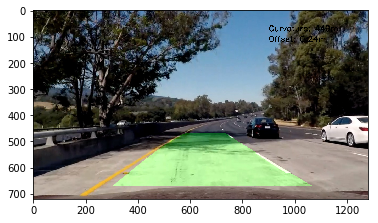

In [36]:
test_image = mpimg.imread('test_images/test5.jpg')
test_output = process_image(test_image)
# plt.imshow(test_image)
# plt.show()
plt.imshow(test_output)
# o = cv2.cvtColor(test_output, cv2.COLOR_RGB2BGR)
# cv2.imwrite('output_images/test.jpg', cv2.cvtColor(test_output, cv2.COLOR_RGB2BGR))

In [37]:
project_output_file = "project_output_3.mp4"
project_video = VideoFileClip("project_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video project_output_3.mp4
[MoviePy] Writing video project_output_3.mp4


100%|█████████▉| 1260/1261 [02:33<00:00,  7.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_3.mp4 

CPU times: user 3min 8s, sys: 44.1 s, total: 3min 52s
Wall time: 2min 34s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output_file))

In [ ]:
challenge_output_file = "challenge_output.mp4"
challenge_video = VideoFileClip("challenge_video.mp4")

challenge_output = challenge_video.fl_image(process_image)
%time challenge_output.write_videofile(challenge_output_file, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_file))

In [ ]:
harder_challenge_output_file = "harder_challenge_output.mp4"
harder_challenge_video = VideoFileClip("harder_challenge_video.mp4")

harder_challenge_output = harder_challenge_video.fl_image(process_image)
%time harder_challenge_output.write_videofile(harder_challenge_output_file, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output_file))